In [1]:
import pandas as pd
import numpy as np
import pickle, gc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from matplotlib import pyplot as plt
import seaborn as sns
from typing import Tuple

from tqdm import tqdm_notebook

import json

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Соревнование American Express - Default Prediction на сайте Kaggle.

В соревновании предоставлены 3 файла с данными: тренировочные, таргет значения для тренировочных данны и тестовые данные.

Цель соревнования состоит в предсказании того, что клиент American Express не вернет остаток средств по своей кредитной карте. Если клиент не платил более 120 дней после последней выписки ему присваивается целевое значение - 1, в ином случае целевое значение равно 0.

На тестовых данных необходимо определить погасит клиент свою задолженость или нет.

В датасете присутствуют столбцы разделенные на следующие группы:

D_*: переменные просроченной задолженности
S_*: расходные переменные
P_*: платежные переменные
B_*: балансовые переменные
R_*: переменные риска

In [2]:
def get_dataset(dataset_path: str) -> pd.DataFrame:
    """
    Получение данных по заданному пути
    :param dataset_path: путь до данных
    :return: датасет
    """

    return pd.read_feather(dataset_path)


train_df = get_dataset('/content/drive/MyDrive/Colab Notebooks/Pet project/train_data.ftr')
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


In [ ]:
print('Размер датасета:', train_df.shape)

Размер датасета: (5531451, 191)


Получение уникальных значений для категориальных признаков, и минимального и максимального значения для числовых признаков

In [ ]:
def unique_features(data: pd.DataFrame) -> dict:
    """
    Получение уникальных данных для категориальных столбцов, и максимольное и
    минимальное значение по числовым столбцам. Полученные данные сохраняются
    в json файле.

    :param data: датасет
    :return: словарь с уникальными значениями
    """

    result_cat = {i: data[i].unique().to_list() for i in
                  data.select_dtypes('category')}
    result_num = data.select_dtypes('float16').agg(['min', 'max'])\
        .to_dict('list')

    unique_data = {'categorical': result_cat, 'numeric': result_num}
    return unique_data
    

unique_features(train_df)

{'categorical': {'D_63': ['CR', 'CO', 'CL', 'XZ', 'XM', 'XL'],
  'D_64': ['O', 'R', '', 'U', '-1'],
  'D_66': [nan, 1.0, 0.0],
  'D_68': [6.0, 2.0, 3.0, nan, 5.0, 4.0, 0.0, 1.0],
  'B_30': [0.0, 2.0, 1.0, nan],
  'B_38': [2.0, 1.0, 3.0, 5.0, 6.0, 7.0, 4.0, nan],
  'D_114': [1.0, 0.0, nan],
  'D_116': [0.0, nan, 1.0],
  'D_117': [4.0, -1.0, 6.0, 2.0, 1.0, nan, 3.0, 5.0],
  'D_120': [0.0, 1.0, nan],
  'D_126': [1.0, nan, 0.0, -1.0]},
 'numeric': {'P_2': [-0.284912109375, 1.009765625],
  'D_39': [8.940696716308594e-07, 5.0078125],
  'B_1': [-0.1414794921875, 1.32421875],
  'B_2': [3.337860107421875e-06, 1.009765625],
  'R_1': [2.980232238769531e-07, 2.50390625],
  'S_3': [-0.2230224609375, 2.587890625],
  'D_41': [6.556510925292969e-07, 4.56640625],
  'B_3': [1.4901161193847656e-06, 1.37109375],
  'D_42': [0.0001347064971923828, 2.556640625],
  'D_43': [9.059906005859375e-06, 3.58203125],
  'D_44': [9.5367431640625e-07, 2.376953125],
  'B_4': [4.76837158203125e-07, 2.1875],
  'D_45': [5.5

## Гипотезы

In [ ]:
def barplot_group(df: pd.DataFrame, col_main: str, col_group: str, title: str) -> None:
    """Построение гистограммы распределения"""

    plt.figure(figsize=(17, 7))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage", hue=col_group, data=data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=10)

    plt.title(title, fontsize=20)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

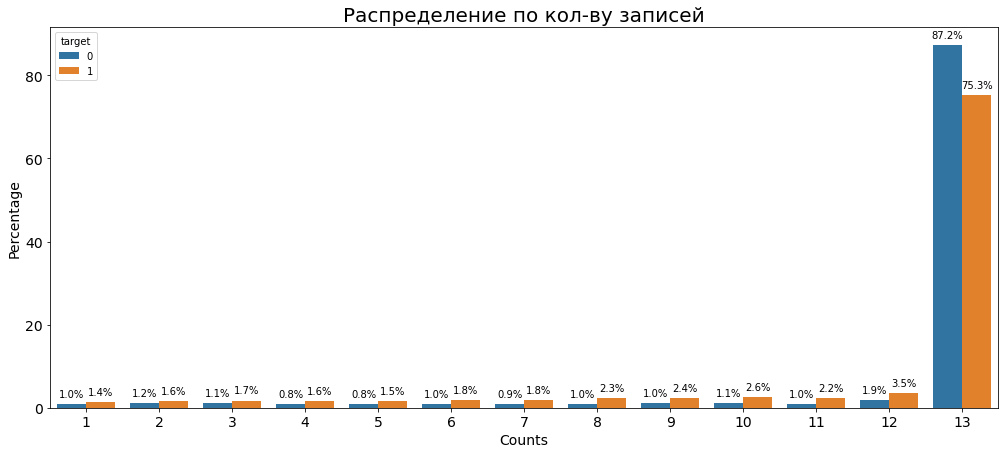

In [ ]:
target_count = train_df.groupby(['customer_ID', 'target'])['S_2'].count()
target_count = pd.DataFrame(target_count).reset_index()\
    .rename(columns={"S_2": "Counts"})

barplot_group(target_count, "Counts", "target", 'Распределение по кол-ву записей')

По диаграмме видно, что с увеличением количества записей о людях возрастает процент неплательщиков (до 13 записи), хотя процент клиентов, которые платят остается стабильным

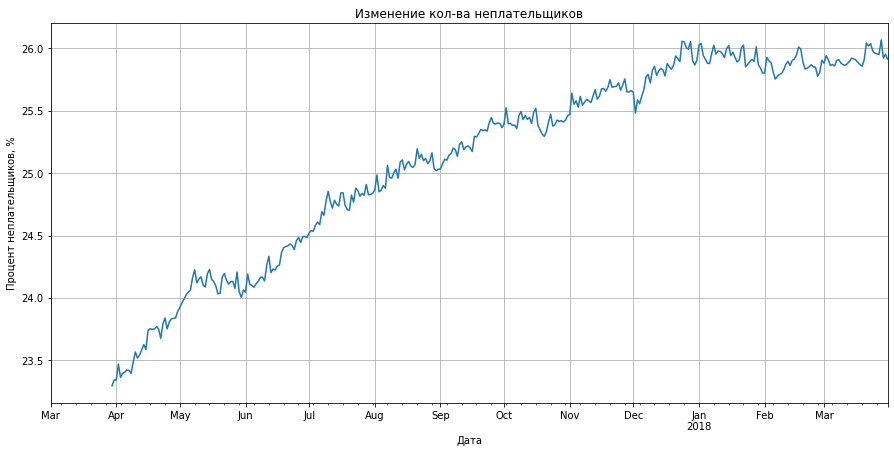

In [ ]:
plt.figure(figsize=(15, 7))

date_ser = train_df.groupby(['S_2'])['target'].mean()
date_ser.rolling('30D', min_periods=30).mean().mul(100).plot(
    title="Изменение кол-ва неплательщиков",
    xlabel='Дата',
    ylabel='Процент неплательщиков, %',
    grid=True
)
None

Количество людей, которые не возвращают деньги, увеличивается начиная с апреля 2017 года и продолжает возростать до января 2018 года. С января и до конца марта 2018 года процент невыплат практически не изменяется.

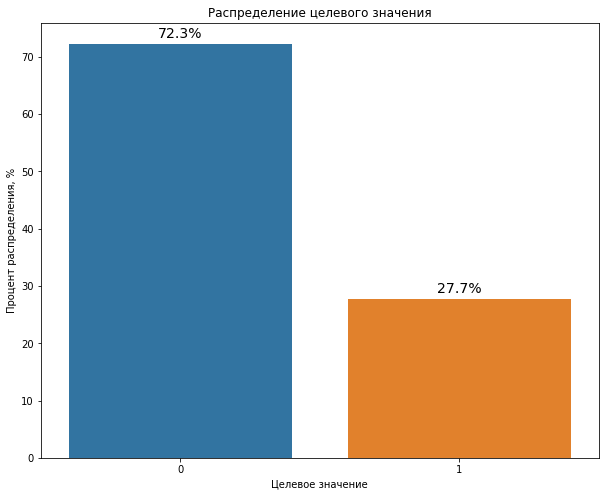

In [ ]:
fig = plt.figure(figsize=(10, 8))
target_dist = train_df.groupby('customer_ID')['target']\
            .last().value_counts(normalize=True).mul(100)

ax = sns.barplot(
    x=target_dist.index,
    y=target_dist
)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=14)
plt.title("Распределение целевого значения")
plt.ylabel("Процент распределения, %")
plt.xlabel("Целевое значение");

В данных наблюдается дисбаланс классов.

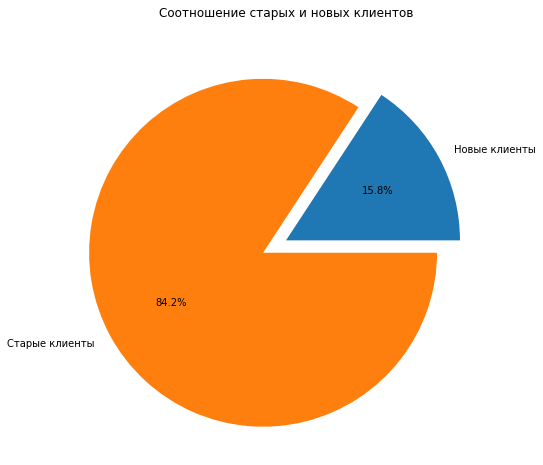

In [ ]:
data = train_df.groupby('customer_ID')['S_2'].count()

fig = plt.figure(figsize=(8, 8))
vals = [data[data < 13].shape[0], data[data == 13].shape[0]]
labels = ['Новые клиенты', 'Старые клиенты']

plt.pie(vals, labels=labels, explode=(0, 0.15), autopct='%1.1f%%')
plt.title('Соотношение старых и новых клиентов');

Из соотношения видно, что количество старых клиентов, которые имеют 13 записей, преобладает над новыми клиентами, у которых записей меньше 13. 

## Feature engineering

In [ ]:
train_df.sort_values(by=['customer_ID', 'S_2'], inplace=True)
train_df.drop(columns='target', inplace=True)

In [ ]:
# Удаление колонок с большим количеством пропусков

many_passes_col = ['D_66']
for i, j in zip(train_df.columns.to_list(), train_df.isnull().mean()):
    if j >= 0.5:
        many_passes_col.append(i)
    
train_df.drop(columns=many_passes_col, inplace=True)
print('Количество удаленных столбцов:', len(many_passes_col))

In [ ]:
# Категориальные и цифровые колонки датасета
cat_col = train_df.select_dtypes(include=['category']).columns.to_list()
dig_col = [i for i in train_df.columns if i not in cat_col + ['S_2', 'customer_ID']]

# Кодирование категориальных данных
le_cat_col = {i: LabelEncoder().fit(train_df[i]) for i in cat_col}

In [ ]:
def preproc_cat_num(
    data: pd.DataFrame, categorical_col: list, numeric_col: list
    ) -> pd.DataFrame:
    """
    Создание новых признаков для категориальных и числовых колонок. Для 
    категориальных признаков: 'count', 'last', 'nunique'. Для числовых 
    признаков: 'mean', 'std', 'min', 'max', 'last', 'quantile25', 'quantile50', 
    'quantile75', '_diff'.

    Параметры:
        data (pd.DataFrame): датафрейм с обрабатываемыми данными
        categorical_col (list): список категориальных столбцов
        numeric_col (list): список числовых столбцов
    Возвращаемое значение:
            result (pd.DataFrame): датафрейм с новыми признаками
    """

    # Применение трансформирования LabelEncoder к категориальным данным
    data[categorical_col] = data[categorical_col].apply(
        lambda col: le_cat_col[col.name].transform(col))

    # Признаки для числовых свойств
    digt_group = data.groupby("customer_ID")[numeric_col]
    data_num_1 = digt_group.agg(['mean', 'std', 'min', 'max', 'last'])\
                                                        .astype('float16')
    data_num_2 = digt_group.quantile([.25, .5, 0.75]).unstack()\
                                                        .astype('float16')
    # Вычисление относительной разницы между последней и предпоследней 
    # датой для каждого признака
    data_num_3 = digt_group.diff(1) / digt_group.shift(periods=1)
    data_num_3 = data_num_3.add_suffix('_diff').astype('float16')
    data_num_3 = pd.concat([data['customer_ID'], data_num_3], axis=1)
    data_num_3 = data_num_3.groupby(['customer_ID']).last().astype('float16')
    
    # Признаки для категориальных свойств
    data_cat = data.groupby("customer_ID")[categorical_col].agg(
        ['count', 'last', 'nunique']).astype('category')

    # Объединение новых числовых и категориальных признаков
    result = pd.concat([data_num_1, data_num_2, data_num_3, data_cat], axis=1)
    result.columns = [
        f'{i[0]}_{i[1]}' if len(i) == 2 else i for i in result.columns
        ]
    
    del data_num_1, data_num_2, data_num_3, data_cat
    gc.collect()
    return result


df = preproc_cat_num(train_df, cat_col, dig_col)
df.shape

In [ ]:
def feature_selection_corr(data: pd.DataFrame, corr_value: float = 0.9) -> list:
    """
    Отбор признаков со значением корреляции ниже установленного в параметре 
    corr_value.

    Параметры:
        data (pd.DataFrame): датафрейм с обрабатываемыми данными
        corr_value (float): значение корреляции выше которого признаки удаляются
    Возвращаемое значение:
            result (list): список столбцов, которые остаются
    """
    
    deleted_colm = []
    left_colm = []

    corr_df = data.corr()
    for col in corr_df.columns:
        corr_list = corr_df[
            (corr_df[col].abs() > corr_value) & (corr_df[col].abs() != 1.0)
        ][col].index.to_list()
        if col not in deleted_colm:
            left_colm.append(col)
        deleted_colm.extend(corr_list)

    return left_colm + data.select_dtypes('category').columns.to_list()


new_column = feature_selection_corr(df)
df = df[new_column]

In [ ]:
def replacing_missing_values(date: pd.DataFrame,
                             change_to: float = -1000.) -> pd.DataFrame:
    """
    Замена пропущенных данных в числовых признаках.
    
    Параметры:
        data (pd.DataFrame): датафрейм с пропущенными данными
        change_to (float): значение на которое заменяется пропущенные значения
    Возвращаемое значение:
        data (pd.DataFrame): датафрейм без пропущенными данными
    """
    
    float_data = date.select_dtypes('float16').columns.to_list()
    not_float = [i for i in date.columns.to_list() if i not in float_data]
    return pd.concat([
        date[not_float], date[float_data].fillna(change_to).astype('float16')
    ],
                     axis=1)


df = replacing_missing_values(df)

In [ ]:
target_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pet project/train_labels.csv')

# Соединение обработанного датафрейма с таргет метками
df = df.merge(target_df, on='customer_ID')

# Сохранение подготовленных тренировочных данных
df.to_feather('train_data_prep.ftr')

del df, train_df
gc.collect()

### Обработка тестовых данных

In [ ]:
test_df = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/Pet project/test_data.ftr')
test_df.sort_values(by=['customer_ID', 'S_2'], inplace=True)

In [ ]:
# Удаление столбцов с большим кол-вом пропусков
test_df.drop(columns=many_passes_col, inplace=True)

test_df = preproc_cat_num(test_df, cat_col, dig_col)

test_df = test_df[new_column]
test_df = replacing_missing_values(test_df)
test_df.reset_index(inplace=True)